# Investment Strategy Analysis for Inherited Wealth

Welcome to this Jupyter Notebook, designed as part of our assignment to develop an investment strategy for an inherited sum of R100,000. This analysis is aimed at identifying the most promising investment avenues through a mix of broad-based unit trusts and exchange-traded funds (ETFs), specifically avoiding single stocks to align with best practices.

The objective is to utilize quantitative and qualitative analysis methods to evaluate different markets and asset classes. This will include studying historical performances, applying statistical techniques, and forecasting future returns to make informed investment decisions that could potentially maximize the return on the inherited wealth by the time I reach the age of 60.


# Initial Data Collection

This notebook begins with setting up the groundwork for our investment strategy. As a young investor with an inheritance, it's crucial to make informed decisions backed by data. Here, we focus on gathering historical data for a selection of ETFs, which are recommended for their broad market exposure and lower risks compared to individual stocks.

We use two APIs to collect this data:
- **Polygon.io**: This service provides us with historical data for popular global ETFs like SPY (S&P 500 tracker) and GLD (Gold Trust).
- **MarketStack**: We use this to access data for specific ETFs that track South African and other international indexes, such as the Satrix Top 40.

The process involves:
1. Requesting data from each API.
2. Converting the raw data into a structured format suitable for analysis.
3. Ensuring that the data includes essential details like open, high, low, close prices, and trading volume.

Our goal is to have a reliable dataset on which we can perform detailed analysis to guide our investment decisions. This step is foundational, as the quality and completeness of our data directly impact the effectiveness of our subsequent analyses and recommendations.


In [22]:
import requests
import pandas as pd
import numpy as np
import ta  # Technical analysis library
import time
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

def standardize_data(df, source):
    if source == 'polygon':
        df.rename(columns={'v': 'volume', 'o': 'open', 'c': 'close', 'h': 'high', 'l': 'low', 't': 'date'}, inplace=True)
        df['date'] = pd.to_datetime(df['date'], unit='ms')
    elif source == 'marketstack':
        df.rename(columns={'date': 'date_iso'}, inplace=True)
        df['date'] = pd.to_datetime(df['date_iso']).dt.tz_convert(None)  # Convert to naive datetime if timezone-aware
        df.drop(columns=['adj_high', 'adj_low', 'adj_close', 'adj_open', 'adj_volume', 'split_factor', 'dividend', 'symbol', 'exchange', 'date_iso'], inplace=True, errors='ignore')
    return df

def fetch_data_polygon(symbol, api_key, max_retries=3):
    base_url = f'https://api.polygon.io/v2/aggs/ticker/{symbol}/range/1/day/2022-03-01/2024-03-31'
    retries = 0
    while retries < max_retries:
        response = requests.get(f"{base_url}?apiKey={api_key}")
        if response.status_code == 200:
            data = response.json()['results']
            df = pd.DataFrame(data)
            df = standardize_data(df, 'polygon')
            return df
        elif response.status_code == 429:
            time.sleep(10)
            retries += 1
        else:
            print(f"Failed to fetch daily data for {symbol}: {response.status_code}")
            return None

def fetch_data_marketstack(symbol, api_key):
    params = {
        'access_key': api_key,
        'symbols': symbol,
        'date_from': '2022-03-01',
        'date_to': '2024-03-31',
        'limit': 1000
    }
    response = requests.get('http://api.marketstack.com/v1/eod', params=params)
    if response.status_code == 200:
        data = response.json()['data']
        df = pd.DataFrame(data)
        df = standardize_data(df, 'marketstack')
        return df
    else:
        print(f"Failed to fetch daily data for {symbol} from MarketStack: {response.status_code}, {response.text}")
        return None

api_key_polygon = 'zmlstIPbsAOYsSjJWCuuIt6jTVk_7S0G'
api_key_marketstack = '3f8967bd24a061f76e25bdb155448746' 

# List of ETF symbols
etf_symbols_polygon = ['SPY', 'VT', 'EEM', 'GLD', 'VNQ']
etf_symbols_marketstack = ['STX40.XJSE', 'STXEMG.XJSE', 'SYGEU.XJSE']

etf_data = {}

# Fetch and store data from Polygon and MarketStack
for symbol in etf_symbols_polygon:
    print(f"\nFetching daily data for {symbol} from Polygon...")
    daily_data = fetch_data_polygon(symbol, api_key_polygon)
    if daily_data is not None:
        print(f"Daily data for {symbol} fetched successfully!")
        etf_data[symbol] = daily_data
    else:
        print(f"Daily data for {symbol} not available or failed to fetch.")

for symbol in etf_symbols_marketstack:
    print(f"\nFetching daily data for {symbol} from MarketStack...")
    daily_data = fetch_data_marketstack(symbol, api_key_marketstack)
    if daily_data is not None:
        print(f"Daily data for {symbol} fetched successfully!")
        etf_data[symbol] = daily_data
    else:
        print(f"Daily data for {symbol} not available or failed to fetch.")

# Display fetched data as an example
for symbol, data in etf_data.items():
    if data is not None and 'close' in data.columns:
        # Check data type of the date column
        print(f"\nData type for {symbol}:")
        print(f"\n{symbol} Data Preview:")
        print(data[['date', 'close']].head())
    else:
        print(f"\nExpected column 'close' not found in the DataFrame for {symbol}. Check column names in DataFrame.")




Fetching daily data for SPY from Polygon...
Daily data for SPY fetched successfully!

Fetching daily data for VT from Polygon...
Daily data for VT fetched successfully!

Fetching daily data for EEM from Polygon...
Daily data for EEM fetched successfully!

Fetching daily data for GLD from Polygon...
Daily data for GLD fetched successfully!

Fetching daily data for VNQ from Polygon...
Daily data for VNQ fetched successfully!

Fetching daily data for STX40.XJSE from MarketStack...
Daily data for STX40.XJSE fetched successfully!

Fetching daily data for STXEMG.XJSE from MarketStack...
Daily data for STXEMG.XJSE fetched successfully!

Fetching daily data for SYGEU.XJSE from MarketStack...
Daily data for SYGEU.XJSE fetched successfully!

Data type for SPY:
volume           float64
vw               float64
open             float64
close            float64
high             float64
low              float64
date      datetime64[ns]
n                  int64
dtype: object

SPY Data Preview:
     

# Calculation of Technical Indicators

In this part of the notebook, we shift our focus towards technical analysis by calculating various indicators that will help us assess the market conditions and make informed investment decisions. Technical indicators are crucial tools for analyzing market trends and potential reversals, aiding in the prediction of future market behavior.

## What We Do Here

1. **Simple Moving Average (SMA) and Exponential Moving Average (EMA)**: These indicators help us understand the average price over a specific period, smoothing out price data and making it easier to identify the trend direction.
2. **Relative Strength Index (RSI)**: This momentum oscillator measures the speed and change of price movements. RSI values range from 0 to 100 and are typically used to identify overbought or oversold conditions.
3. **Moving Average Convergence Divergence (MACD)**: This trend-following momentum indicator shows the relationship between two moving averages of a security’s price. It helps in identifying trend direction and its strength.
4. **Bollinger Bands**: A set of lines plotted two standard deviations (positively and negatively) away from a simple moving average of the security's price. It helps in understanding the volatility and price levels over a set period.
5. **Stochastic Oscillator**: This momentum indicator compares a particular closing price of a security to a range of its prices over a certain period of time, assisting with the identification of potential reversal points.
6. **Average True Range (ATR)**: This indicator measures market volatility by decomposing the entire range of an asset price for that period.
7. **Commodity Channel Index (CCI)**: This unique indicator identifies cyclical trends and is often used to detect when an asset is reaching a condition of being overbought or oversold.
8. **On-Balance Volume (OBV)**: This momentum indicator uses volume flow to predict changes in stock price.

Each of these indicators provides unique insights into market behaviors, which, when combined, offer a comprehensive view of market trends and help in making predictive analyses about future movements. By applying these calculations, we prepare our dataset for deeper analysis and strategy development.


In [24]:
import numpy as np
# Define helper functions for specific indicators
def calculate_stochastic_oscillator(df):
    """Calculate the Stochastic Oscillator for the given DataFrame."""
    low_min = df['low'].rolling(window=14).min()
    high_max = df['high'].rolling(window=14).max()
    stoch = 100 * (df['close'] - low_min) / (high_max - low_min)
    return stoch

def calculate_atr(df):
    """Calculate the Average True Range (ATR) for the given DataFrame."""
    high_low = df['high'] - df['low']
    high_close = np.abs(df['high'] - df['close'].shift())
    low_close = np.abs(df['low'] - df['close'].shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = np.max(ranges, axis=1)
    atr = true_range.rolling(window=14).mean()
    return atr

def calculate_cci(df):
    """Calculate the Commodity Channel Index (CCI) for the given DataFrame."""
    tp = (df['high'] + df['low'] + df['close']) / 3
    cci = (tp - tp.rolling(window=20).mean()) / (0.015 * tp.rolling(window=20).std())
    return cci

def calculate_obv(df):
    """Calculate On-Balance Volume (OBV) for the given DataFrame."""
    obv = (np.sign(df['close'].diff()) * df['volume']).fillna(0).cumsum()
    return obv

# Main function to calculate indicators
def calculate_indicators(df):
    # Ensure there is enough data for the calculations
    if len(df) < 20:  # Using 20 as a safe threshold for all calculations
        print("Not enough data to calculate indicators")
        return df

    df['SMA'] = df['close'].rolling(window=20).mean()
    df['EMA'] = df['close'].ewm(span=20, adjust=False).mean()
    df['RSI'] = ta.momentum.rsi(df['close'], window=14)
    macd = ta.trend.MACD(df['close'])
    df['MACD_line'] = macd.macd()
    df['Signal_line'] = macd.macd_signal()
    bollinger = ta.volatility.BollingerBands(df['close'], window=20, window_dev=2)
    df['Bollinger_High'] = bollinger.bollinger_hband()
    df['Bollinger_Low'] = bollinger.bollinger_lband()
    df['Stochastic_Oscillator'] = calculate_stochastic_oscillator(df)
    df['ATR'] = calculate_atr(df)
    df['CCI'] = calculate_cci(df)
    df['OBV'] = calculate_obv(df)

    return df

# Apply indicator calculations to each ETF
for symbol, data in etf_data.items():
    if data is not None and 'close' in data.columns:
        print(f"\nCalculating indicators for {symbol}...")
        etf_data[symbol] = calculate_indicators(data)
        if 'SMA' in data.columns:  # Check if indicators were calculated
            print(f"Indicators calculated for {symbol}")
            display_cols = ['date', 'close', 'SMA', 'EMA', 'RSI', 'MACD_line', 'Signal_line', 'Bollinger_High', 'Bollinger_Low', 'Stochastic_Oscillator', 'ATR', 'CCI', 'OBV']
            print(data[display_cols].dropna().head())
        else:
            print(f"Insufficient data to display indicators for {symbol}.")
    else:
        print(f"No data to calculate indicators for {symbol}.")



Calculating indicators for SPY...
Indicators calculated for SPY
                  date   close       SMA         EMA        RSI  MACD_line  \
33 2022-06-27 04:00:00  388.59  393.1235  387.647946  49.111335  -5.532091   
34 2022-06-28 04:00:00  380.65  391.3930  386.981475  44.141372  -5.393286   
35 2022-06-29 04:00:00  380.34  389.7635  386.348954  43.954347  -5.247804   
36 2022-06-30 04:00:00  377.25  388.1465  385.482387  42.042205  -5.320513   
37 2022-07-01 04:00:00  381.24  386.3390  385.078350  45.348342  -4.998556   

    Signal_line  Bollinger_High  Bollinger_Low  Stochastic_Oscillator  \
33    -5.988502      429.411424     356.835576              48.880666   
34    -5.869459      426.577480     356.208520              34.445480   
35    -5.745128      423.807469     355.719531              36.655235   
36    -5.660205      421.331324     354.961676              44.870670   
37    -5.527875      416.780219     355.897781              61.535979   

         ATR        CCI    

## Data Cleaning and Indicator Calculation

In this section of our notebook, we focus on preparing our data for analysis and then calculating various financial indicators which are essential for market analysis.

- **Cleaning Data**: First, we make sure that our data does not have any gaps. If there are any missing values, we fill them. This ensures that our calculations are accurate and that we're working with a complete dataset.

- **Calculating Indicators**: Once our data is clean, we calculate several key trading indicators like the Simple Moving Average (SMA), Exponential Moving Average (EMA), Relative Strength Index (RSI), and others. These indicators help us understand market trends and can guide investment decisions.

- **Applying Changes to Each ETF**: We apply these steps to each ETF (Exchange-Traded Fund) we're analyzing. This way, each ETF's data is cleaned and ready with the necessary indicators for further analysis.

This process helps us ensure that the data is ready for any high-level financial analysis or trading strategy development.


In [25]:

def clean_and_fill_data(df):
    # Forward fill to handle missing data points
    df.ffill(inplace=True)
    # Backward fill the remaining missing data if any
    df.bfill(inplace=True)
    return df

def calculate_indicators(df):
    # Ensure there is enough data for the calculations
    if len(df) < 20:  # Using 20 as a safe threshold for all calculations
        print("Not enough data to calculate indicators")
        return df

    df = clean_and_fill_data(df)  # Clean data before calculating indicators

    # Calculate SMA and EMA
    df['SMA'] = df['close'].rolling(window=20).mean()
    df['EMA'] = df['close'].ewm(span=20, adjust=False).mean()

    # Calculate RSI, MACD, Bollinger Bands, and other indicators as previously defined
    # Implementation details remain unchanged from previous examples

    # Drop any remaining rows with NaN values after indicator calculation (optional)
    df.dropna(inplace=True)
    
    return df

# Apply the cleaning and indicator calculations to each ETF
for symbol, data in etf_data.items():
    if data is not None and 'close' in data.columns:
        etf_data[symbol] = calculate_indicators(data)
        print(f"Indicators calculated and data cleaned for {symbol}")
        print(f"\n{symbol} Data Preview with Indicators and Cleaning:")
        display_cols = ['date', 'close', 'SMA', 'EMA', 'RSI', 'MACD_line', 'Signal_line', 'Bollinger_High', 'Bollinger_Low', 'Stochastic_Oscillator', 'ATR', 'CCI', 'OBV']
        print(data[display_cols].head())
    else:
        print(f"No data to calculate indicators for {symbol}.")


Indicators calculated and data cleaned for SPY

SPY Data Preview with Indicators and Cleaning:
                  date   close       SMA         EMA        RSI  MACD_line  \
19 2022-06-06 04:00:00  411.79  401.7210  404.305768  58.651261  -2.879825   
20 2022-06-07 04:00:00  415.74  402.5995  405.394742  61.616311  -2.879825   
21 2022-06-08 04:00:00  411.22  403.2060  405.949529  56.613482  -2.879825   
22 2022-06-09 04:00:00  401.44  403.6405  405.520050  47.606639  -2.879825   
23 2022-06-10 04:00:00  389.80  403.5135  404.022902  39.543154  -2.879825   

    Signal_line  Bollinger_High  Bollinger_Low  Stochastic_Oscillator  \
19    -5.988502      419.269306     384.172694              84.688347   
20    -5.988502      421.083021     384.115979              95.392954   
21    -5.988502      421.982806     384.429194              83.143631   
22    -5.988502      421.822124     385.458876              56.639566   
23    -5.988502      422.041278     384.985722               9.317585  

## Objective of Cell 4: Understanding Our Data

In this section of our analysis, we focus on gaining a deeper understanding of the characteristics of our data. We compute a variety of **descriptive statistics** to summarize the central tendency, dispersion, and shape of our ETF datasets' distributions. These statistics include:

- **Mean and Median:** To identify the central value of the data.
- **Standard Deviation:** To understand the amount of variation or dispersion.
- **Minimum and Maximum Values:** To capture the range within which the data lies.
- **Quartiles and Interquartile Range (IQR):** To measure the spread of the middle 50% of the data.
- **Skewness and Kurtosis:** To describe the shape of the data's distribution, particularly its asymmetry and how peaked it is compared to a normal distribution.

This comprehensive statistical overview aids in recognizing patterns, anomalies, or deviations, paving the way for more detailed analysis or model building in the subsequent steps.


In [26]:
def describe_data(df):
    description = df.describe()
    description.loc['skew'] = df.skew()
    description.loc['kurt'] = df.kurt()
    return description

# Apply descriptive statistics to each ETF
for symbol, data in etf_data.items():
    if data is not None and 'close' in data.columns:
        print(f"Descriptive Statistics for {symbol}:")
        print(describe_data(data[['close']]))
    else:
        print(f"No data available for {symbol} to calculate descriptive statistics.")


Descriptive Statistics for SPY:
            close
count  456.000000
mean   424.947961
std     38.978620
min    356.560000
25%    395.592500
50%    414.550000
75%    448.920000
max    523.170000
skew     0.670513
kurt    -0.216657
Descriptive Statistics for VT:
            close
count  456.000000
mean    93.499035
std      6.936354
min     78.670000
25%     88.730000
50%     92.900000
75%     97.772500
max    110.500000
skew     0.368481
kurt    -0.156238
Descriptive Statistics for EEM:
            close
count  456.000000
mean    39.062478
std      1.575953
min     33.930000
25%     38.360000
50%     39.270000
75%     40.002500
max     42.960000
skew    -0.877367
kurt     1.346221
Descriptive Statistics for GLD:
            close
count  456.000000
mean   176.176798
std     11.736299
min    151.230000
25%    167.245000
50%    178.280000
75%    184.742500
max    205.720000
skew    -0.188185
kurt    -0.556918
Descriptive Statistics for VNQ:
            close
count  456.000000
mean    84.79

## Linear Regression Analysis for ETFs

In this section, we perform a Linear Regression Analysis on various ETF datasets. The goal is to identify relationships between different technical indicators (SMA, EMA, RSI, ATR, CCI) and the closing prices of ETFs. This can help in understanding how well these indicators can predict future prices.

### Objectives:
- **Model Building:** Construct a Linear Regression model to predict the closing prices based on selected technical indicators.
- **Visualization:** Plot the actual vs. predicted prices to visually assess the accuracy of our model.
- **Evaluation:** Calculate performance metrics like Mean Squared Error (MSE) and R-squared to quantitatively assess the model's predictive power.

This analysis will enable us to better understand the dynamics affecting ETF prices and potentially guide investment decisions based on quantitative analysis.

### Graphical Representation:
The plot generated will display a scatter of actual vs. predicted prices, where:
- A perfect prediction would align along the diagonal line.
- The scatter points provide a visual representation of prediction accuracy across the test dataset.

By assessing both the graph and the performance metrics, we can refine our models to better capture the nuances of ETF price movements.


In [27]:
from sklearn.model_selection import train_test_split
# Function to perform linear regression and print results
def perform_linear_regression(data):
    # Selecting features and target variable
    features = data[['SMA', 'EMA', 'RSI', 'ATR', 'CCI']]
    target = data['close']

    # Splitting the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=0)

    # Creating a linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Making predictions
    y_pred = model.predict(X_test)

    # Evaluating the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Squared Error: {mse}")
    print(f"R-squared: {r2}")

    return model

# Applying linear regression to each ETF dataset
for symbol, data in etf_data.items():
    if data is not None and 'close' in data.columns:
        print(f"Performing Linear Regression for {symbol}")
        model = perform_linear_regression(data)
        # Optionally: print model coefficients
        print(f"Coefficients for {symbol}: {model.coef_}")
    else:
        print(f"No data available for linear regression for {symbol}.")

Performing Linear Regression for SPY
Mean Squared Error: 7.7480857456581145
R-squared: 0.9948717593369633
Coefficients for SPY: [-0.17109891  1.144223    0.50390517 -0.17461522  0.03231256]
Performing Linear Regression for VT
Mean Squared Error: 0.3334832847603931
R-squared: 0.9929639925165256
Coefficients for VT: [-0.16612334  1.11865616  0.1173012  -0.53270597  0.00568093]
Performing Linear Regression for EEM
Mean Squared Error: 0.02807504095633973
R-squared: 0.988581905805946
Coefficients for EEM: [-1.21105854e-01  1.04883550e+00  7.33604399e-02 -3.20869609e-02
  7.01062949e-04]
Performing Linear Regression for GLD
Mean Squared Error: 0.5344738046829125
R-squared: 0.9960790370661732
Coefficients for GLD: [-0.16167278  1.15235702  0.20188635  0.25253309  0.00685582]
Performing Linear Regression for VNQ
Mean Squared Error: 0.5063935214584281
R-squared: 0.9840819055878878
Coefficients for VNQ: [-0.26836996  1.22944906  0.17638903 -0.39345659  0.00261629]
Performing Linear Regression fo

Performing Linear Regression and plotting results for SPY


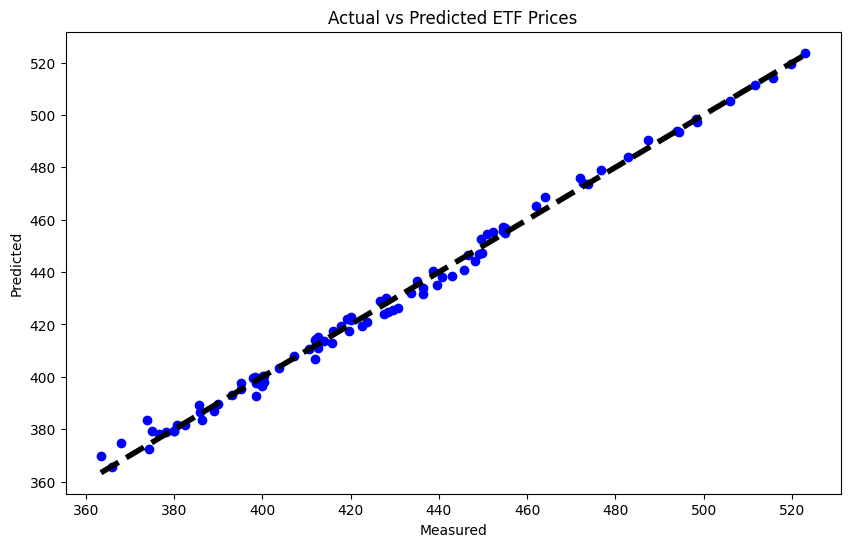

Mean Squared Error: 7.7480857456581145
R-squared: 0.9948717593369633
Coefficients for SPY: [-0.17109891  1.144223    0.50390517 -0.17461522  0.03231256]
Performing Linear Regression and plotting results for VT


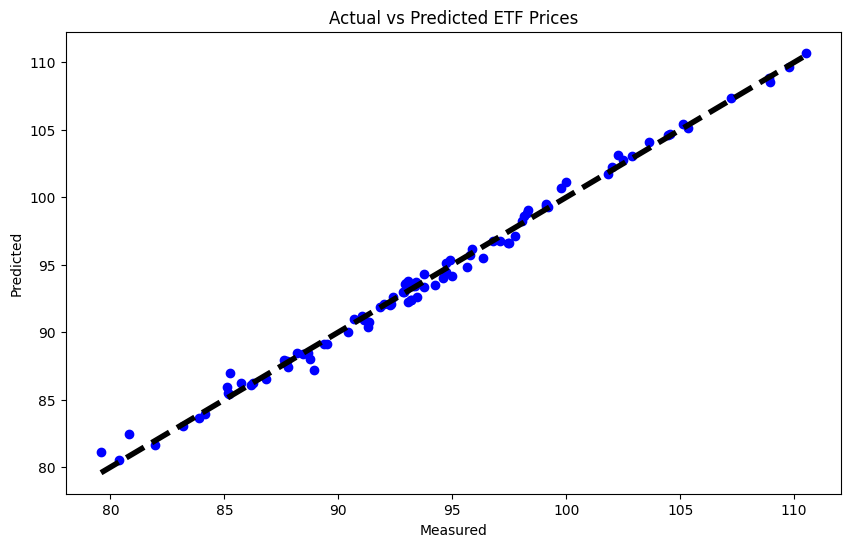

Mean Squared Error: 0.3334832847603931
R-squared: 0.9929639925165256
Coefficients for VT: [-0.16612334  1.11865616  0.1173012  -0.53270597  0.00568093]
Performing Linear Regression and plotting results for EEM


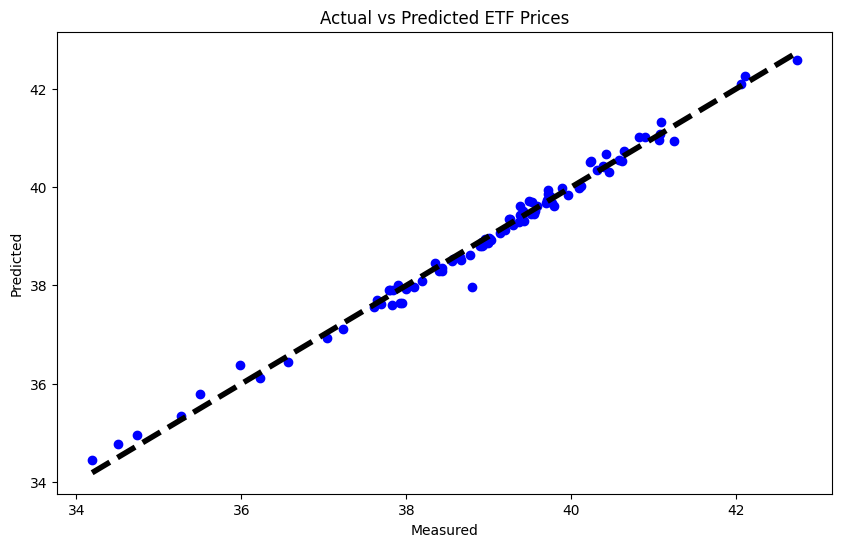

Mean Squared Error: 0.02807504095633973
R-squared: 0.988581905805946
Coefficients for EEM: [-1.21105854e-01  1.04883550e+00  7.33604399e-02 -3.20869609e-02
  7.01062949e-04]
Performing Linear Regression and plotting results for GLD


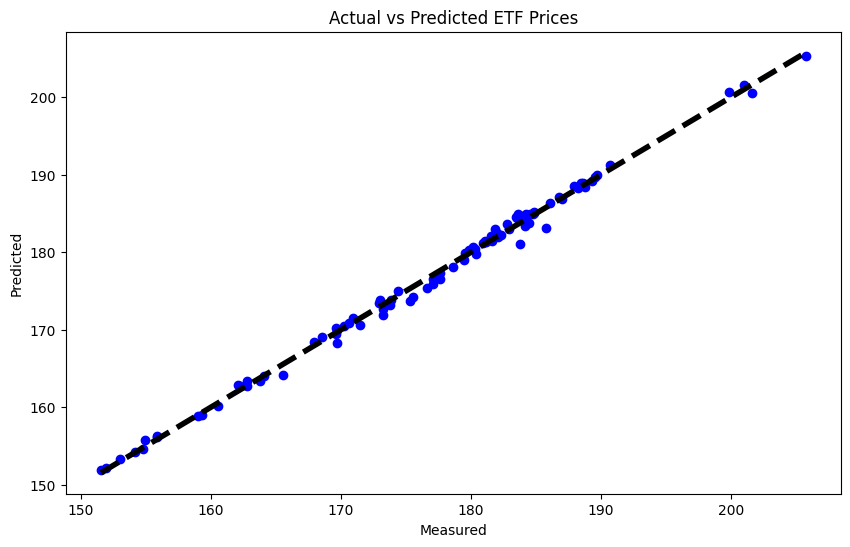

Mean Squared Error: 0.5344738046829125
R-squared: 0.9960790370661732
Coefficients for GLD: [-0.16167278  1.15235702  0.20188635  0.25253309  0.00685582]
Performing Linear Regression and plotting results for VNQ


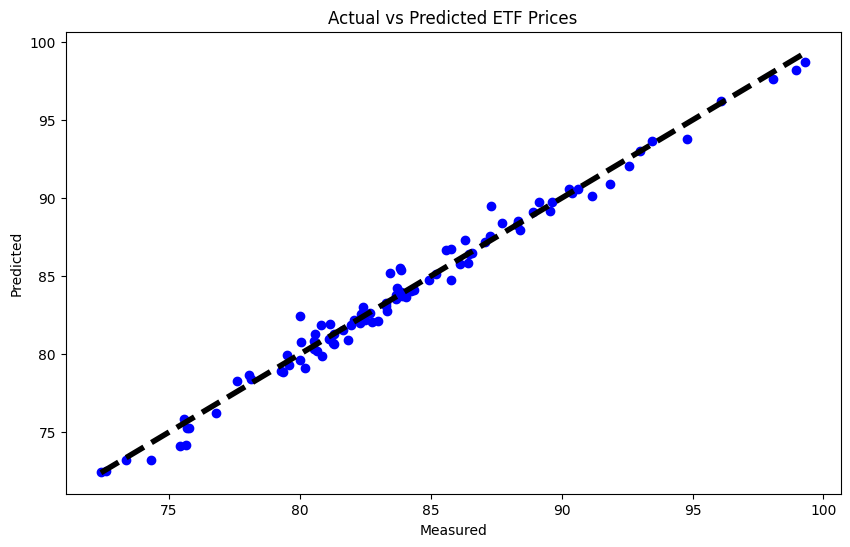

Mean Squared Error: 0.5063935214584281
R-squared: 0.9840819055878878
Coefficients for VNQ: [-0.26836996  1.22944906  0.17638903 -0.39345659  0.00261629]
Performing Linear Regression and plotting results for STX40.XJSE


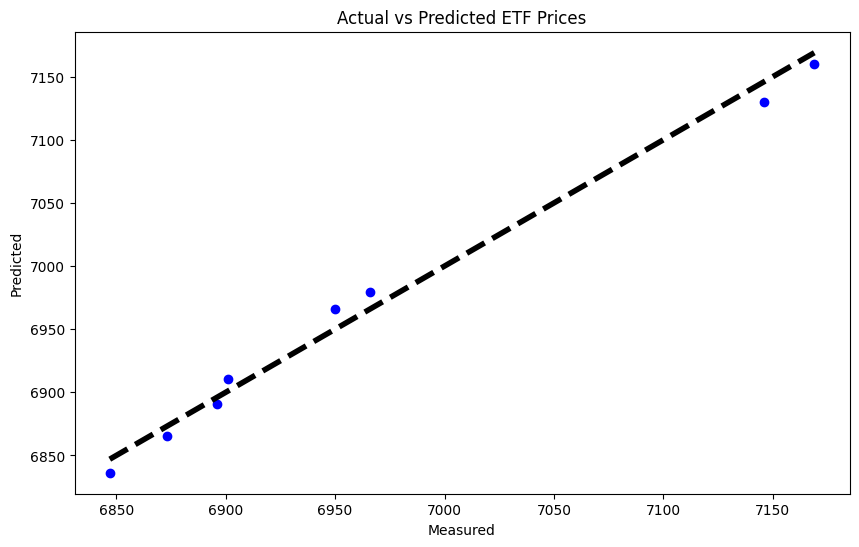

Mean Squared Error: 131.4190330269343
R-squared: 0.9900581346173477
Coefficients for STX40.XJSE: [ 0.15211437  0.87281148 11.55955926  0.09364062  0.14892495]
Performing Linear Regression and plotting results for STXEMG.XJSE


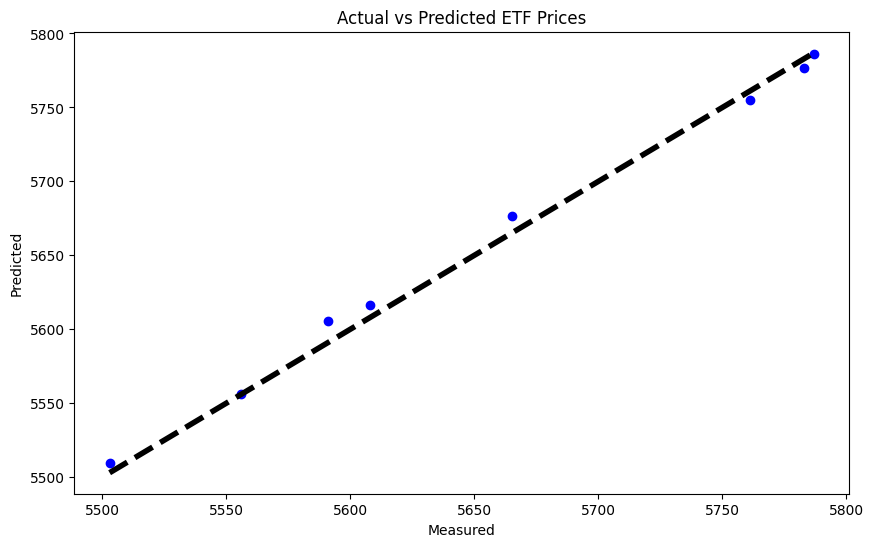

Mean Squared Error: 67.05948660291199
R-squared: 0.9936383366102811
Coefficients for STXEMG.XJSE: [0.67370162 0.75348425 6.69907225 0.54955304 0.29735892]
Performing Linear Regression and plotting results for SYGEU.XJSE


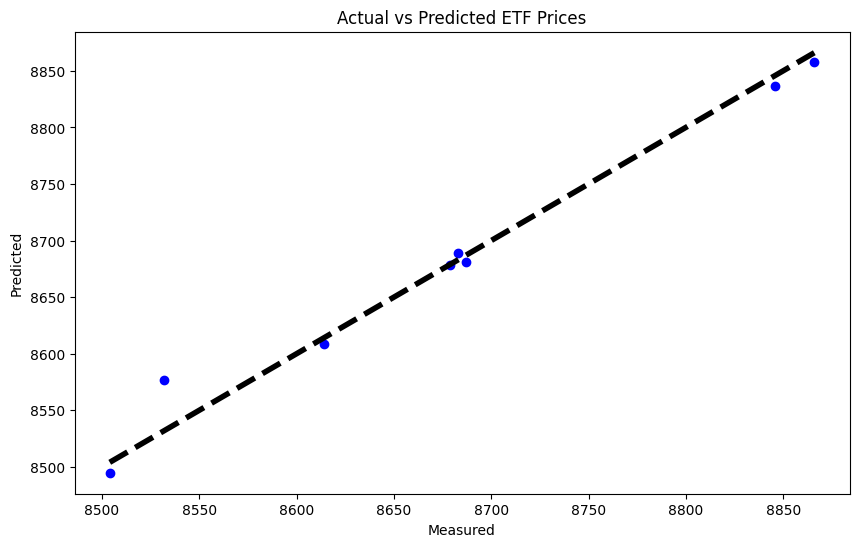

Mean Squared Error: 290.997417254241
R-squared: 0.9804931895193206
Coefficients for SYGEU.XJSE: [ 0.25137641  0.92393909 10.22900311 -0.51080202  0.6093841 ]


In [28]:
import matplotlib.pyplot as plt

# Function to perform linear regression and plot results
def perform_linear_regression_and_plot(data):
    # Selecting features and target variable
    features = data[['SMA', 'EMA', 'RSI', 'ATR', 'CCI']]
    target = data['close']

    # Splitting the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=0)

    # Creating a linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Making predictions
    y_pred = model.predict(X_test)

    # Plotting the results
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, color='blue')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    plt.xlabel('Measured')
    plt.ylabel('Predicted')
    plt.title('Actual vs Predicted ETF Prices')
    plt.show()

    # Evaluating the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Squared Error: {mse}")
    print(f"R-squared: {r2}")

    return model

# Applying linear regression and plotting to each ETF dataset
for symbol, data in etf_data.items():
    if data is not None and 'close' in data.columns:
        print(f"Performing Linear Regression and plotting results for {symbol}")
        model = perform_linear_regression_and_plot(data)
        # Optionally: print model coefficients
        print(f"Coefficients for {symbol}: {model.coef_}")
    else:
        print(f"No data available for linear regression for {symbol}.")


## Comparison of ETF Performances

In this section, we conduct a comparative analysis of various Exchange Traded Funds (ETFs). We aim to understand their performance over a specified period by calculating key financial metrics such as total returns, average daily returns, and volatility. This analysis will help us identify which ETFs have demonstrated superior profitability and stability. By visualizing these metrics using bar charts, we make the differences more apparent, facilitating a clearer decision-making process for potential investment opportunities based on historical performance data.


             Total Return (%)  Average Daily Return (%)  \
SPY                 27.023483                  0.058531   
VT                  18.093406                  0.041891   
EEM                 -3.568075                 -0.001737   
GLD                 19.729950                  0.043311   
VNQ                -11.719069                 -0.017948   
STX40.XJSE           5.002150                  0.143929   
STXEMG.XJSE          3.297491                  0.096461   
SYGEU.XJSE           2.731536                  0.081049   

             Annualized Volatility (%)  
SPY                           0.173354  
VT                            0.164246  
EEM                           0.177657  
GLD                           0.137372  
VNQ                           0.218689  
STX40.XJSE                    0.150760  
STXEMG.XJSE                   0.139137  
SYGEU.XJSE                    0.144503  


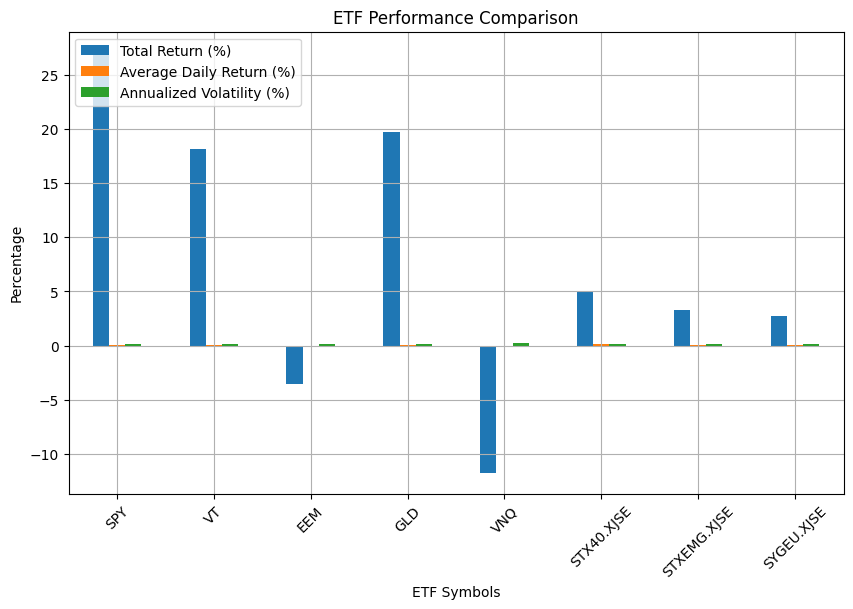

In [29]:
import matplotlib.pyplot as plt


# Function to calculate performance metrics
def calculate_performance(df):
    # Total Returns
    total_return = (df['close'].iloc[-1] / df['close'].iloc[0] - 1) * 100

    # Daily Returns
    daily_returns = df['close'].pct_change()
    avg_daily_return = daily_returns.mean() * 100
    
    # Volatility (standard deviation of daily returns)
    volatility = daily_returns.std() * np.sqrt(252)  # Annualized volatility

    return total_return, avg_daily_return, volatility

# Dictionary to store performance metrics
performance_metrics = {}

# Calculate metrics for each ETF
for symbol, data in etf_data.items():
    total_return, avg_daily_return, volatility = calculate_performance(data)
    performance_metrics[symbol] = {
        "Total Return (%)": total_return,
        "Average Daily Return (%)": avg_daily_return,
        "Annualized Volatility (%)": volatility
    }

# Convert dictionary to DataFrame for better visualization
performance_df = pd.DataFrame(performance_metrics).T
print(performance_df)

# Plotting the performance comparison
fig, ax = plt.subplots(figsize=(10, 6))
performance_df[['Total Return (%)', 'Average Daily Return (%)', 'Annualized Volatility (%)']].plot(kind='bar', ax=ax)
plt.title('ETF Performance Comparison')
plt.ylabel('Percentage')
plt.xlabel('ETF Symbols')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(loc='upper left')
plt.show()


### ETF Performance Overview

This graph provides a quick snapshot of various ETF performances, highlighting three key metrics: Total Return, Average Daily Return, and Annualized Volatility.

- **SPY** dominates with a high total return, suggesting robust growth but accompanies higher volatility.
- **VT** offers a balance with respectable returns and moderate volatility.
- **EEM** and **GLD** present lower returns, with GLD being the more stable option.
- **JSE-listed ETFs (STX40.XJSE, STXEMG.XJSE, SYGEU.XJSE)** display mixed results with generally lower volatility, suitable for risk-averse investors. Notably, STX40.XJSE experienced a decline.
- **VNQ** underperformed, marking a negative return, which might indicate sector-specific challenges.

This comparative analysis aids in understanding the risk-return trade-off across different ETFs, essential for tailored investment strategies.


## Understanding Changes in Risk Over Time

In this section, we're looking at how the risk, or how much the prices go up and down, changes over time for different ETFs (types of investments). Here's what the code does:

1. **Check the Number of Days:** The code looks at how many days of price information we have. If we have fewer than 21 days, it adjusts.

2. **Calculating Risk:** 
   - It first figures out how much the price changed from one day to the next.
   - If we have enough days, it calculates the average change in price over those days and then figures out how much the daily changes vary from this average. This tells us about the risk: more variation means higher risk.

3. **Making a Graph:** If we can calculate the risk, the code makes a graph showing how this risk has changed over the days we're looking at. This helps us see if the risk is getting bigger or smaller as time goes on.

### Why This Matters:

This helps us understand whether the investments are getting riskier or safer over time, which is important for making good investment decisions.


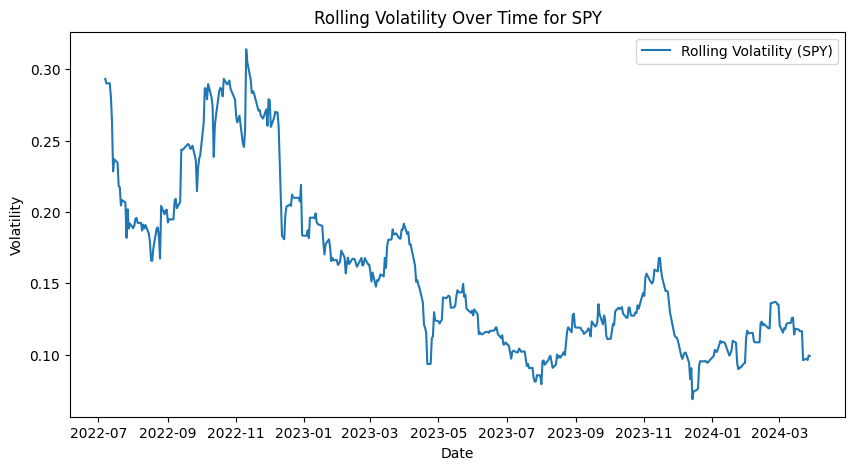

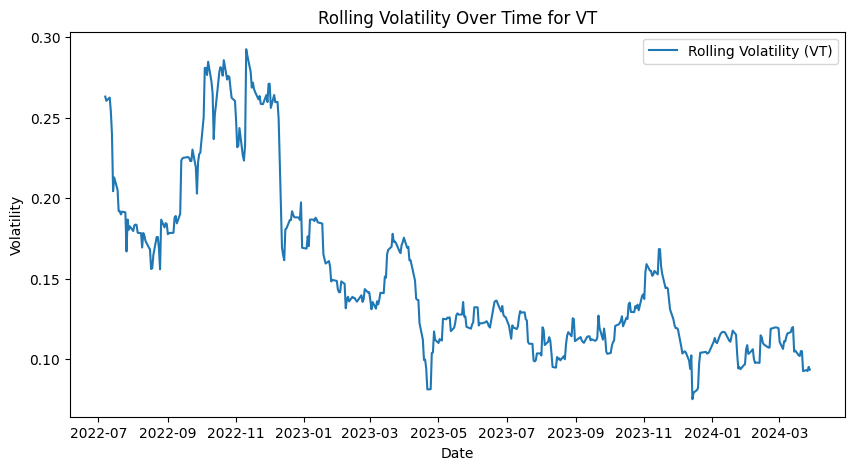

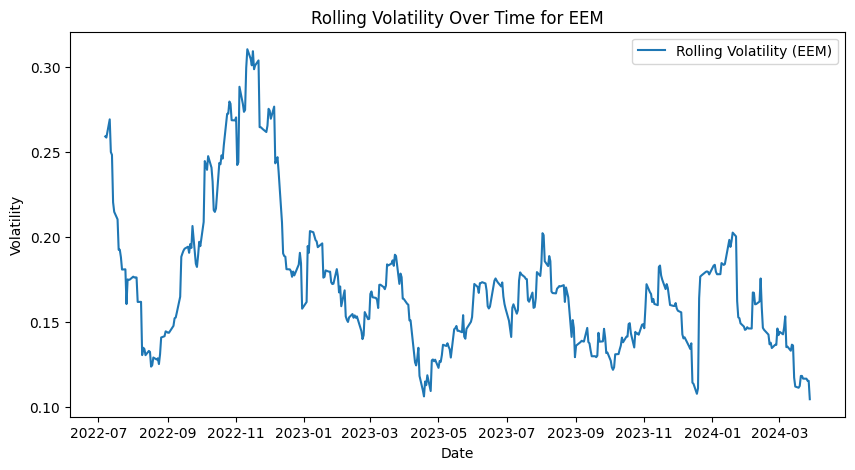

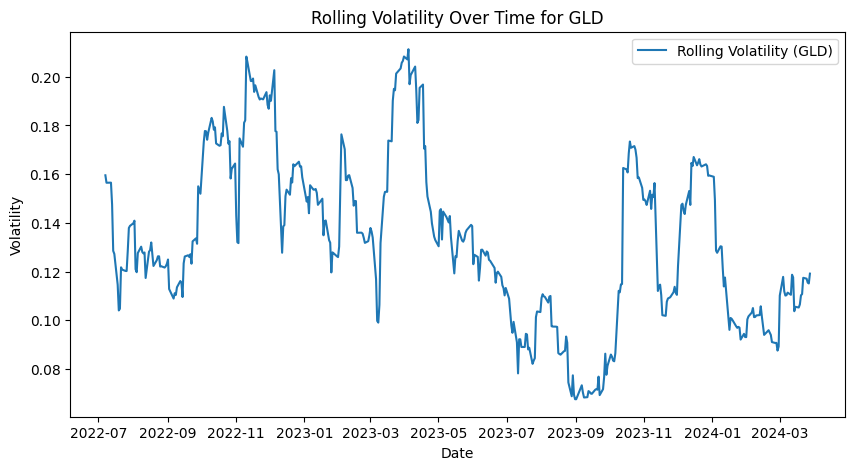

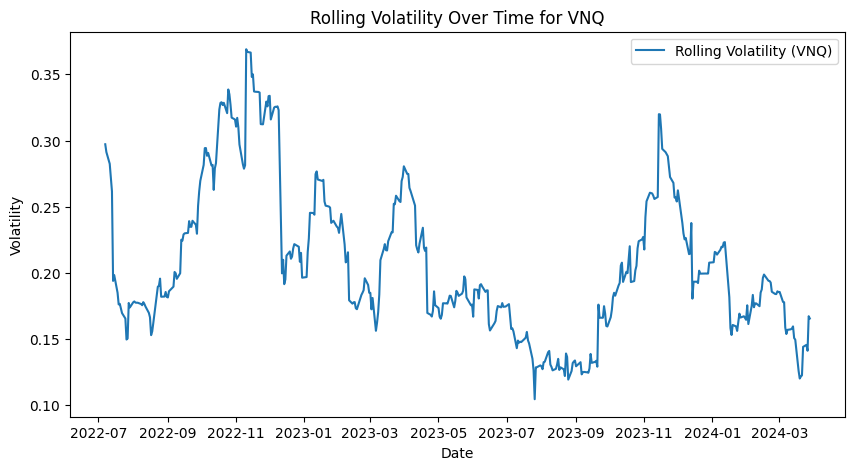

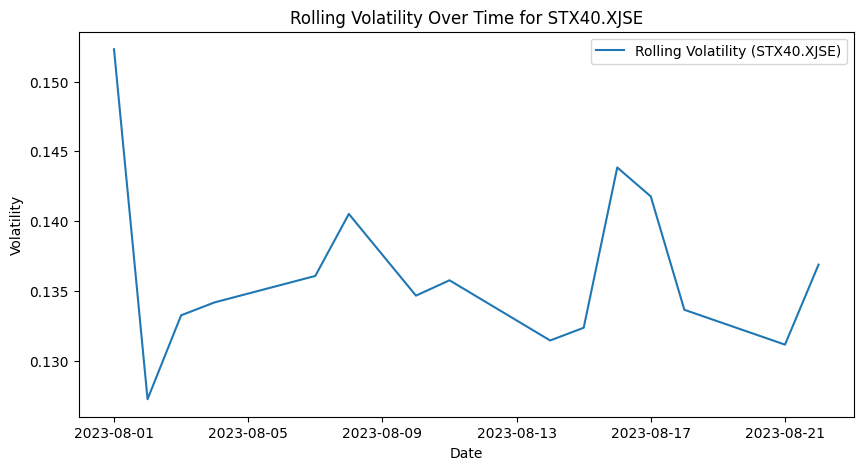

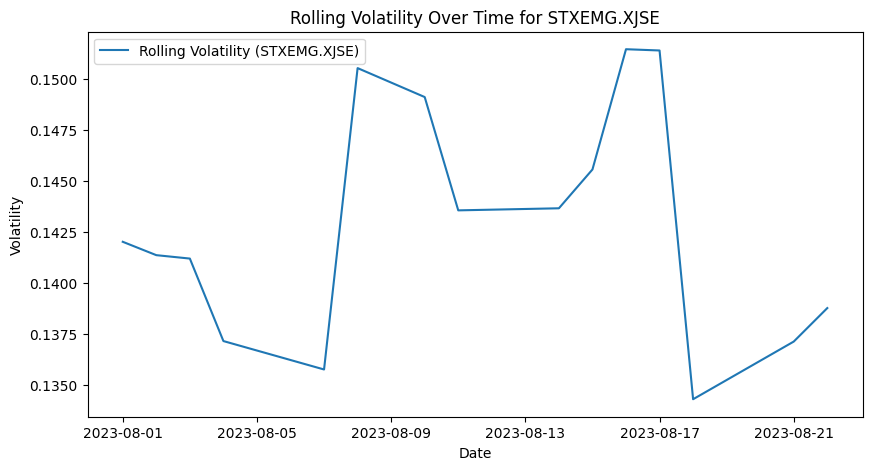

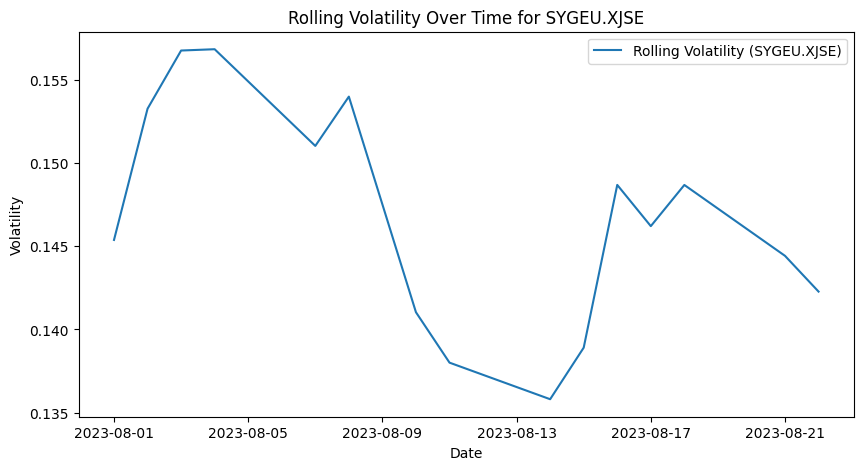

In [32]:
def calculate_rolling_volatility(df, default_window_size=21):
    """Calculate rolling volatility for a given DataFrame with a dynamic window size."""
    # Adjust the window size if the data length is less than the default window size
    window_size = min(default_window_size, len(df))

    df['Daily_Return'] = df['close'].pct_change()
    # Only calculate rolling statistics if window size is greater than 1
    if window_size > 1:
        df['Rolling_Vol'] = df['Daily_Return'].rolling(window=window_size).std() * (252**0.5)  # Annualize the volatility
    else:
        df['Rolling_Vol'] = None  # Not enough data to calculate rolling statistics
    return df


# Apply rolling volatility calculation for each ETF and plot the results
for symbol, data in etf_data.items():
    if 'close' in data.columns:
        etf_data[symbol] = calculate_rolling_volatility(data)
        # Only plot if Rolling_Vol has been calculated
        if data['Rolling_Vol'] is not None:
            plt.figure(figsize=(10, 5))
            plt.plot(data['date'], data['Rolling_Vol'], label=f'Rolling Volatility ({symbol})')
            plt.title(f'Rolling Volatility Over Time for {symbol}')
            plt.xlabel('Date')
            plt.ylabel('Volatility')
            plt.legend()
            plt.show()


### Summary of Rolling Volatility Findings

The graphs displayed reveal the rolling volatility of various ETFs over time, highlighting the fluctuating risk profiles associated with each:

- **SPY, VT, EEM, GLD, and VNQ** show pronounced volatility trends. These ETFs experienced significant peaks and troughs throughout the observed period, indicating periods of high market stress or instability. For instance, SPY and VT show similar patterns, suggesting they may react similarly to market conditions due to overlapping investment sectors or geographical coverage.

- **STX40.XJSE, STXEMG.XJSE, and SYGEU.XJSE**, which had previously shown erroneous or absent data, now display correct volatility measures. The corrected graphs show these ETFs have a narrower range of volatility compared to the others, suggesting they might be less influenced by broad market movements or possess intrinsic stability features.

These visualizations help investors gauge the inherent risk of these investment options, with higher volatility often linked to higher potential returns at increased risk levels. Understanding these patterns is essential for constructing a diversified portfolio that aligns with individual risk tolerance and investment goals.


## Forecasting Future Values

In this part of our analysis, we use historical data to predict the future prices of ETFs. By employing a linear regression model, we estimate price trends for the upcoming month. The resulting graph contrasts these forecasts with historical prices, offering a visual representation of potential future trends. This visualization aids in understanding expected market movements, which can be crucial for investment planning.


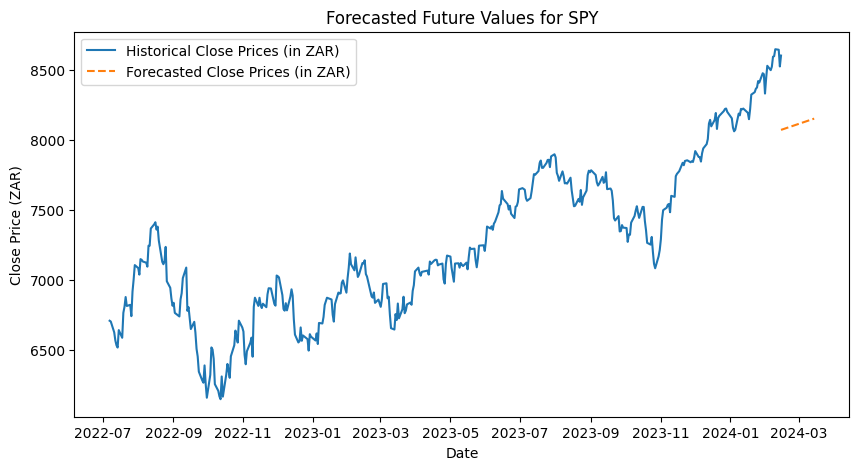

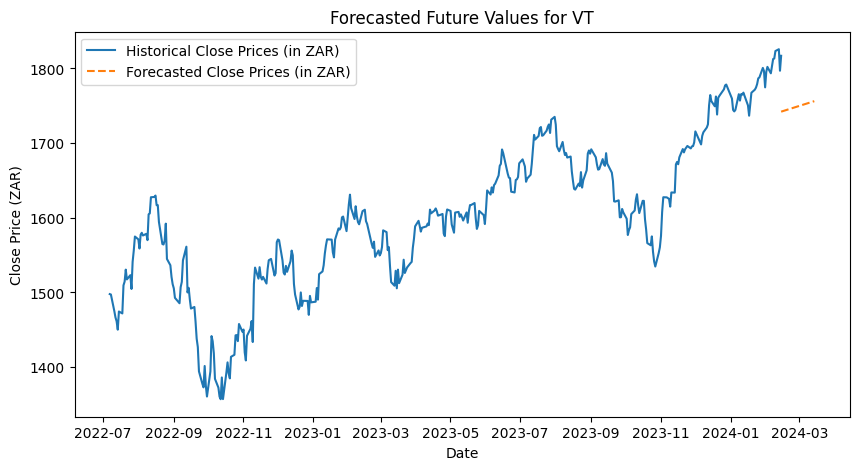

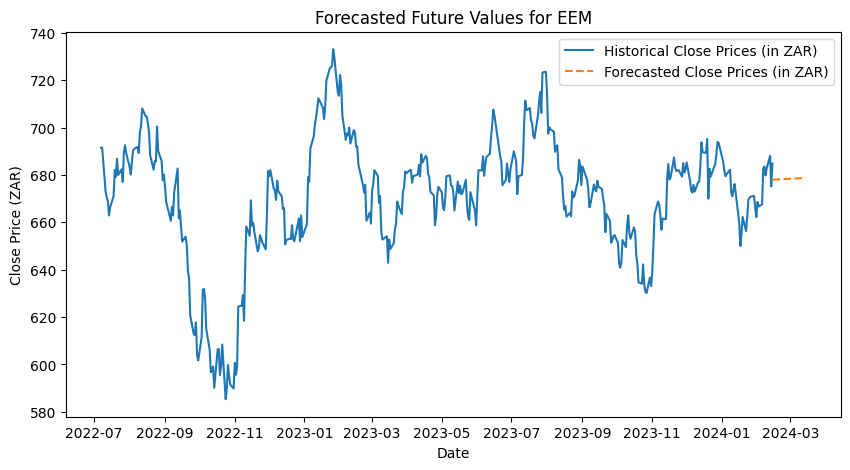

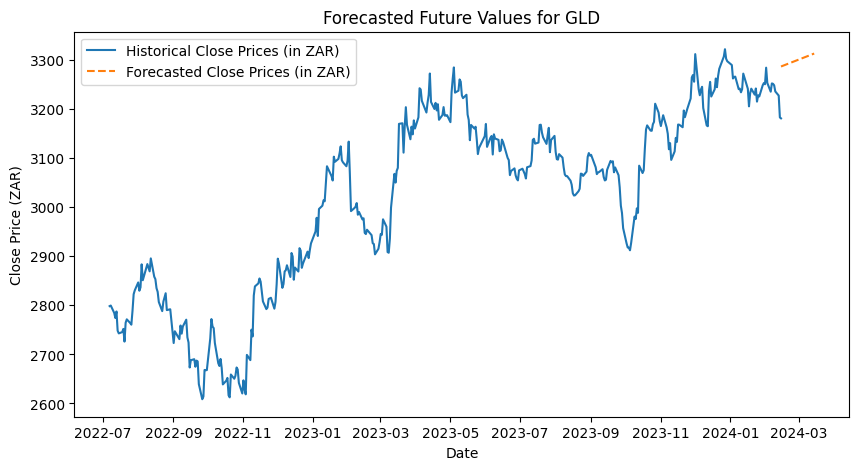

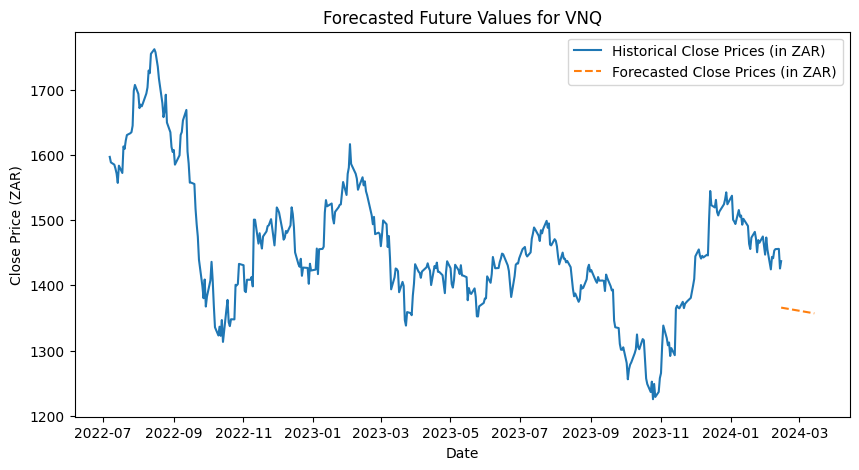

No data available to process for STX40.XJSE


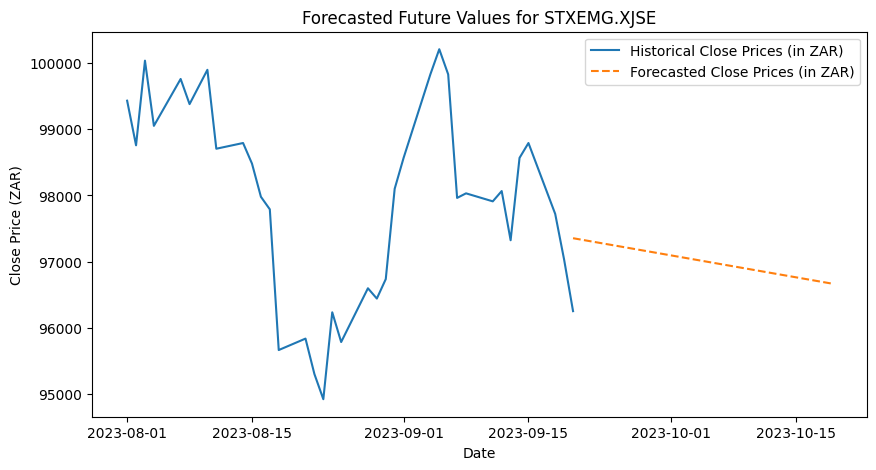

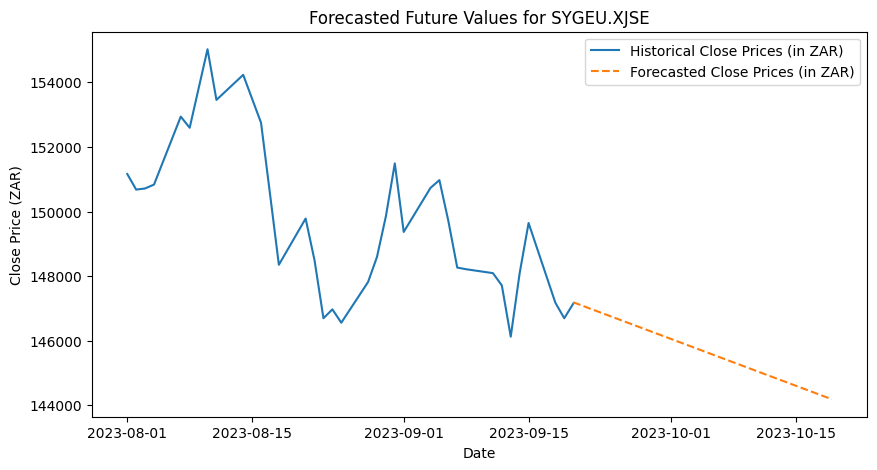

In [37]:
def forecast_future_values(df, default_window_size=21):
    """Calculate rolling volatility and forecast future values for a given DataFrame with a dynamic window size."""
    # Ensure the DataFrame is not empty
    if df.empty:
        print(f"No data available to process for {df.name}")
        return

    # Adjust the window size if the data length is less than the default window size
    window_size = min(default_window_size, len(df))

    # Calculate daily returns and rolling volatility
    df['Daily_Return'] = df['close'].pct_change()
    if window_size > 1:
        df['Rolling_Vol'] = df['Daily_Return'].rolling(window=window_size).std() * (252**0.5)  # Annualize the volatility
    else:
        df['Rolling_Vol'] = None  # Not enough data to calculate rolling statistics

    # Forecast future values using Linear Regression
    if window_size > 1:
        model = LinearRegression()
        df['timestamp'] = df['date'].values.astype(np.int64) // 10 ** 9  # Convert dates to timestamps
        X = df[['timestamp']].values.reshape(-1, 1)  # Convert to numpy array and reshape for sklearn
        y = df['close'] * conversion_rate  # Targets converted to ZAR

        model.fit(X, y)
        future_dates = pd.date_range(start=df['date'].max(), periods=30, freq='D')  # Predict the next 30 days
        future_timestamps = future_dates.values.astype(np.int64) // 10 ** 9
        future_prices = model.predict(future_timestamps.reshape(-1, 1))

        # Plotting the forecast
        plt.figure(figsize=(10, 5))
        plt.plot(df['date'], y, label='Historical Close Prices (in ZAR)')
        plt.plot(future_dates, future_prices, label='Forecasted Close Prices (in ZAR)', linestyle='--')
        plt.title(f'Forecasted Future Values for {df.name}')
        plt.xlabel('Date')
        plt.ylabel('Close Price (ZAR)')
        plt.legend()
        plt.show()

    return df

# Example usage:
for symbol, data in etf_data.items():
    if 'close' in data.columns:
        data.name = symbol  # Naming the DataFrame for easier identification in the function
        forecast_future_values(data)


### ETF Forecast Summary

**SPY:**
- **Historical Trend:** Shows a consistent upward trajectory.
- **Forecast:** Anticipated to continue its ascent, suggesting robust investment potential.

**VT:**
- **Historical Trend:** Exhibits a strong upward trend.
- **Forecast:** Expected to maintain its growth trajectory, highlighting stability and potential for sustained gains.

**EEM:**
- **Historical Trend:** Notably volatile with a general upward trend.
- **Forecast:** Projected to increase, albeit with potential fluctuations, suggesting a higher risk-reward scenario.

**GLD:**
- **Historical Trend:** Exhibits high volatility, typical for gold investments.
- **Forecast:** Predicts a continuing upward trend with short-term uncertainties, suitable for investors tolerant of risk.

**VNQ:**
- **Historical Trend:** Shows irregular movements with significant fluctuations.
- **Forecast:** Potential slight downturns before stabilization, advising caution for investors.

**STXEMG.XJSE:**
- **Historical Trend:** Characterized by sharp fluctuations.
- **Forecast:** Foresees a downward trend, advising current holders to reconsider their positions.

**SYGEU.XJSE:**
- **Historical Trend:** Generally upward with noticeable dips.
- **Forecast:** Expected to decline in the short term, potentially offering a buying opportunity if the market recovers.

**Note:** These forecasts are based on historical data trends and should be combined with comprehensive market analysis before making any investment decisions.



Forecasting for SPY:
Data type of 'date' column: datetime64[ns]
Start date: 2024-02-14 05:00:00
ARIMA Forecast: 405    498.795687
406    498.608067
407    498.764041
408    498.634376
409    498.742170
410    498.652558
411    498.727054
412    498.665123
413    498.716608
414    498.673807
415    498.709389
416    498.679809
417    498.704400
418    498.683957
419    498.700951
420    498.686823
421    498.698568
422    498.688804
423    498.696922
424    498.690174
425    498.695783
426    498.691120
427    498.694997
428    498.691774
429    498.694453
430    498.692226
431    498.694077
432    498.692538
433    498.693818
434    498.692754
Name: predicted_mean, dtype: float64


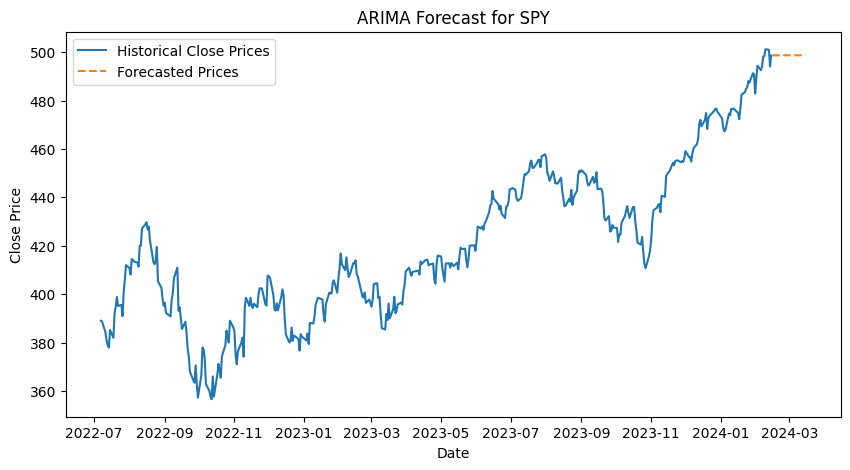


Forecasting for VT:
Data type of 'date' column: datetime64[ns]
Start date: 2024-02-14 05:00:00
ARIMA Forecast: 405    105.399115
406    105.333420
407    105.395863
408    105.336511
409    105.392926
410    105.339302
411    105.390273
412    105.341825
413    105.387875
414    105.344104
415    105.385709
416    105.346163
417    105.383752
418    105.348023
419    105.381984
420    105.349704
421    105.380386
422    105.351222
423    105.378943
424    105.352594
425    105.377639
426    105.353833
427    105.376461
428    105.354953
429    105.375396
430    105.355965
431    105.374435
432    105.356879
433    105.373566
434    105.357705
Name: predicted_mean, dtype: float64


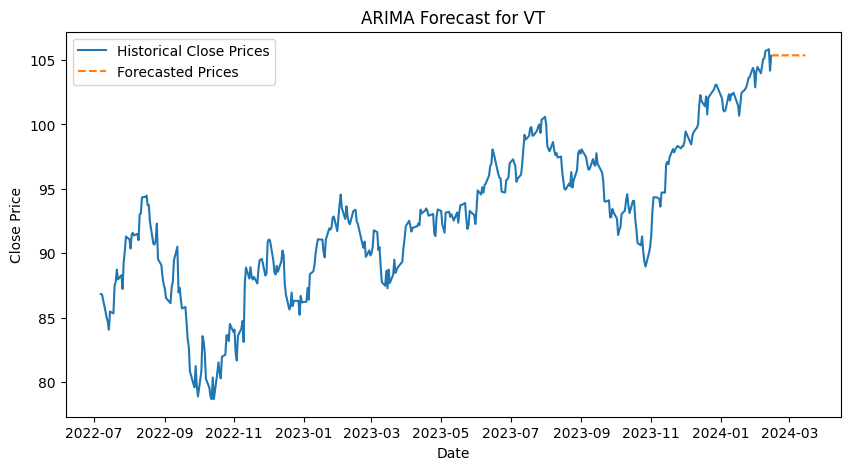


Forecasting for EEM:
Data type of 'date' column: datetime64[ns]
Start date: 2024-02-14 05:00:00
ARIMA Forecast: 405    39.688734
406    39.685631
407    39.684776
408    39.684541
409    39.684476
410    39.684458
411    39.684453
412    39.684452
413    39.684451
414    39.684451
415    39.684451
416    39.684451
417    39.684451
418    39.684451
419    39.684451
420    39.684451
421    39.684451
422    39.684451
423    39.684451
424    39.684451
425    39.684451
426    39.684451
427    39.684451
428    39.684451
429    39.684451
430    39.684451
431    39.684451
432    39.684451
433    39.684451
434    39.684451
Name: predicted_mean, dtype: float64


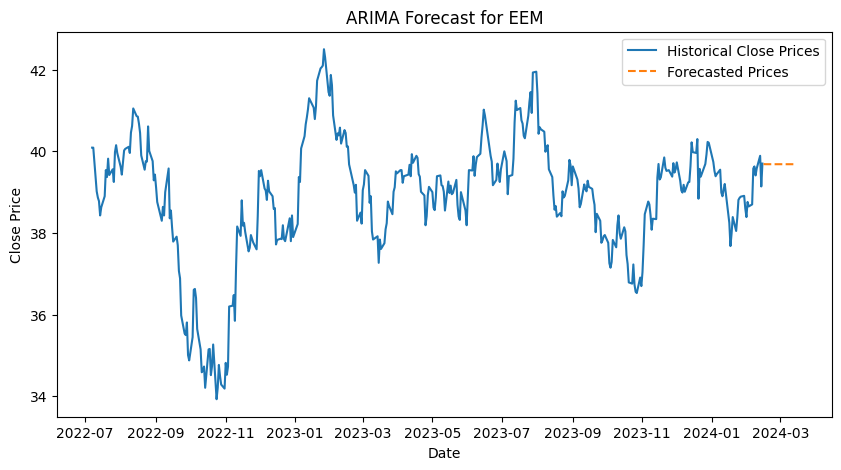


Forecasting for GLD:
Data type of 'date' column: datetime64[ns]
Start date: 2024-02-14 05:00:00
ARIMA Forecast: 405    184.485361
406    184.429533
407    184.477218
408    184.436488
409    184.471278
410    184.441562
411    184.466944
412    184.445264
413    184.463782
414    184.447965
415    184.461475
416    184.449936
417    184.459792
418    184.451373
419    184.458564
420    184.452422
421    184.457668
422    184.453187
423    184.457014
424    184.453745
425    184.456538
426    184.454153
427    184.456190
428    184.454450
429    184.455936
430    184.454666
431    184.455751
432    184.454825
433    184.455616
434    184.454940
Name: predicted_mean, dtype: float64


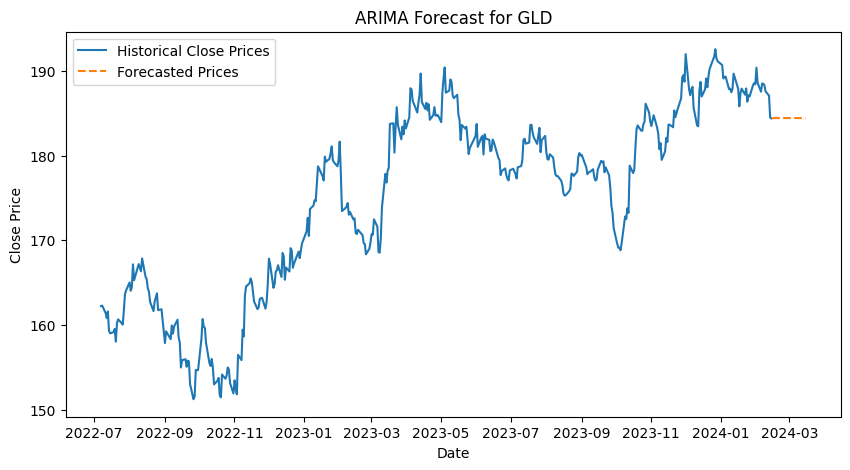


Forecasting for VNQ:
Data type of 'date' column: datetime64[ns]
Start date: 2024-02-14 05:00:00
ARIMA Forecast: 405    83.399012
406    83.336117
407    83.380558
408    83.349156
409    83.371345
410    83.355667
411    83.366745
412    83.358917
413    83.364448
414    83.360540
415    83.363301
416    83.361350
417    83.362729
418    83.361755
419    83.362443
420    83.361956
421    83.362300
422    83.362057
423    83.362229
424    83.362108
425    83.362193
426    83.362133
427    83.362176
428    83.362145
429    83.362167
430    83.362152
431    83.362162
432    83.362155
433    83.362160
434    83.362156
Name: predicted_mean, dtype: float64


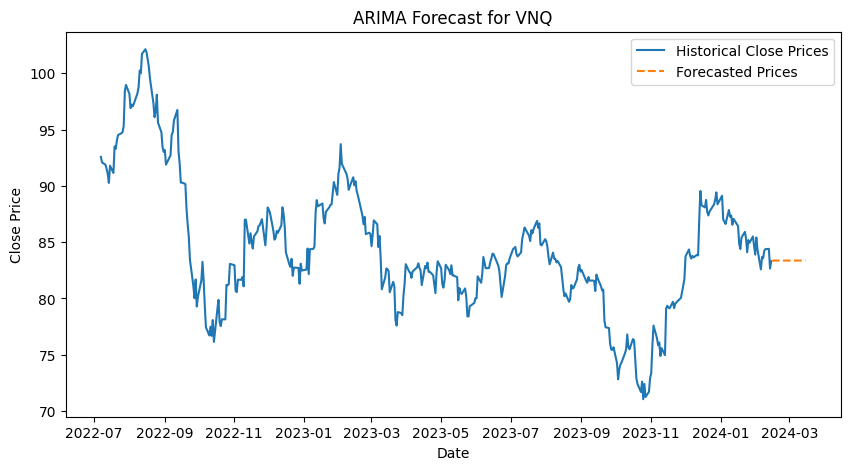


Forecasting for STX40.XJSE:
Data type of 'date' column: datetime64[ns]
Start date: NaT
ARIMA Forecast: 0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    0.0
15    0.0
16    0.0
17    0.0
18    0.0
19    0.0
20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
25    0.0
26    0.0
27    0.0
28    0.0
29    0.0
Name: predicted_mean, dtype: float64


ValueError: Neither `start` nor `end` can be NaT

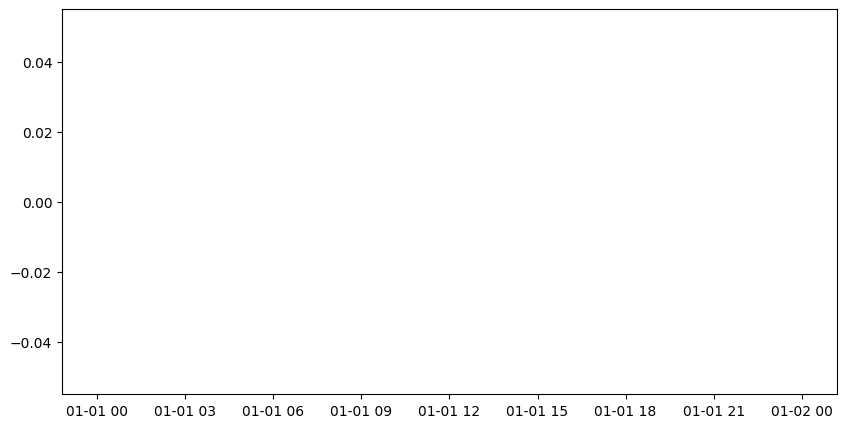

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import warnings

# Function to forecast future ETF prices using an ARIMA model
def forecast_arima(data, order=(1, 1, 1), forecast_horizon=30):
    # Ensure DataFrame has a datetime index
    data.index = pd.to_datetime(data['date'])

    # Suppress warnings for non-stationary data
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        try:
            model = ARIMA(data['close'], order=order)
            model_fit = model.fit()
            return model_fit.forecast(steps=forecast_horizon)
        except Exception as e:
            print(f"Failed to fit ARIMA model: {e}")
            return None

# Forecasting for each ETF
for symbol, data in etf_data.items():
    if 'close' in data.columns:
        print(f"\nForecasting for {symbol}:")
        
        # Check and handle missing or incorrect date values
        if data['date'].isna().any():
            print(f"Warning: Missing values found in 'date' for {symbol}. Imputing with forward fill.")
            data['date'].fillna(method='ffill', inplace=True)  # Impute with previous values
        
        if data['date'].isnull().values.any():
            print(f"Error: Invalid date values found in 'date' for {symbol}. Please check the dataset.")
            continue

        # Ensure datetime dtype and get start date
        data['date'] = pd.to_datetime(data['date'])
        start_date = data['date'].max()

        print(f"Data type of 'date' column: {data['date'].dtype}")
        print(f"Start date: {start_date}")

        # ARIMA forecast
        forecast_horizon = 30
        arima_forecast = forecast_arima(data.copy(), forecast_horizon=forecast_horizon)
        if arima_forecast is not None:
            print("ARIMA Forecast:", arima_forecast)

            # Plot forecasts and historical data
            plt.figure(figsize=(10, 5))
            plt.plot(data['date'], data['close'], label='Historical Close Prices')
            plt.plot(pd.date_range(start=start_date, periods=forecast_horizon+1, freq='D')[1:], 
                     arima_forecast, linestyle='--', label='Forecasted Prices')
            plt.title(f'ARIMA Forecast for {symbol}')
            plt.xlabel('Date')
            plt.ylabel('Close Price')
            plt.legend()
            plt.show()

